In [21]:
import torch
from torch import nn,optim
from torch.autograd import Variable
from  torch.nn import init
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from seqInit import toTs
from seqInit import input_size,train,real

In [49]:
#定义LSTM 模型
class lstmModel(nn.Module):
    def __init__(self,in_dim,hidden_dim,out_dim,layer_num):
        super().__init__()
        self.lstm=nn.LSTM(in_dim,hidden_dim,layer_num,batch_first=True)
        self.fc=nn.Linear(hidden_dim,out_dim)

        self.weightInit=(np.sqrt(1.0/hidden_dim))

    def forward(self, x):         # x dim : (batch,time_step,input_size)
        out,_=self.lstm(x)
        #b,s,h=out.size() #batch,time_step(seq), hidden
        out=out[:,12:,:]
        out=self.fc(out)
        return out
    
    #初始化权重
    def weightInit(self, gain=1):
            # 使用初始化模型参数
        for name, param in self.named_parameters():
            if 'lstmLayer.weight' in name:
                init.orthogonal(param, gain)

In [51]:
# 输入维度为1，输出维度为1，隐藏层维数为5, 定义LSTM层数为2
lstm = lstmModel(1, 5, 1, 2)

# 定义损失函数和优化函数
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr = 1e-2)

# 处理输入
def create_dataset(dataset) :
    data = dataset.reshape(1, -1, 1)
    return torch.from_numpy(data)

trainX = create_dataset(train[:-1])   #train[:-1]是(119,1)，最后trainX是（1,119,1），由第1~119的数当trainX
trainY = create_dataset(train[1:])[:,12:,:]  #train[1:]是(119,1)，最后trainY是（1,107,1），由第14~120的数当trainY，与trainX错位表示有滞后性

# 训练模型
frq, sec = 3500, 350
loss_set = []

for e in range(1, frq + 1) :
    inputs = trainX
    target = trainY
    #forward
    output = lstm(inputs)
    loss = criterion(output, target)
    # update paramters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print training information
    print_loss = loss.item()
    loss_set.append((e, print_loss))
    if e % sec == 0 :
        print('Epoch[{}/{}], Loss: {:.5f}'.format(e, frq, print_loss))

Epoch[350/3500], Loss: 0.00644
Epoch[700/3500], Loss: 0.00234
Epoch[1050/3500], Loss: 0.00165
Epoch[1400/3500], Loss: 0.00069
Epoch[1750/3500], Loss: 0.00058
Epoch[2100/3500], Loss: 0.00055
Epoch[2450/3500], Loss: 0.00056
Epoch[2800/3500], Loss: 0.00051
Epoch[3150/3500], Loss: 0.00046
Epoch[3500/3500], Loss: 0.00043


In [52]:
lstm = lstm.eval()
# 预测结果并比较
px = real[:-1].reshape(1, -1, 1)
px = torch.from_numpy(px)
ry = real[1:].reshape(-1)
py = lstm(px).data
py = np.array(py).reshape(-1)
print(px.shape, py.shape, ry.shape)

torch.Size([1, 143, 1]) (131,) (143,)


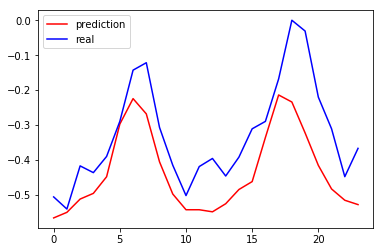

In [53]:
# 画出实际结果和预测的结果
plt.plot(py[-24:], 'r', label='prediction')
plt.plot(ry[-24:], 'b', label='real')
plt.legend(loc='best')